# Neural Network for Hadronic Top Reconstruction
This file creates a feed-forward binary classification neural network for hadronic top reconstruction by classifying quark jet triplets as being from a top quark or not.

In [1]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
from sklearn import preprocessing
import torch as th
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchsample as tsamp
from sklearn.metrics import f1_score, roc_auc_score

/home/drnevich/miniconda3/envs/ROOT/lib/python2.7/site-packages/torchsample-0.1.3-py2.7.egg/torchsample/modules/_utils.py:8: UserWarning: inspect.signature not available... you should upgrade to Python 3.x


In [2]:
def find_cut(model, dataset, n_steps=100, benchmark="f1"):
    X, y = Variable(dataset[:]['input']).float(), dataset[:]['target'].type(th.ByteTensor).view(-1, 1)
    out = model(X).data
    best_cut = 0
    best_score = -1
    for i in range(n_steps+1):
        cut = i*((out.max() - out.min())/n_steps) + out.min()
        if benchmark == "f1":
            score = f1_score(y.numpy(), (out >= cut).type(th.ByteTensor).numpy())
        elif benchmark == "acc":
            score = ((out >= cut).type(th.ByteTensor) == y).sum()
        if score > best_score:
            best_score = score
            best_cut = cut
    return best_cut

In [3]:
def score(model, dataset, cut=0.5):
    X, y = Variable(dataset[:]['input']).float(), dataset[:]['target'].type(th.ByteTensor).view(-1, 1)
    out = model(X).data
    predicted = (out >= cut).type(th.ByteTensor)
    return (predicted == y).sum()/out.size()[0]

## Generate Datasets for Training and Testing

In [4]:
class CollisionDataset(Dataset):
    def __init__(self, datafile, header=None, scaler=None, target_col=0, index_col=None):
        self.dataframe = pd.read_csv(datafile, header=header, index_col=index_col)
        self._X = pd.concat([self.dataframe.iloc[:, :target_col], self.dataframe.iloc[:, target_col+1:]], axis=1)
        self._y = self.dataframe.iloc[:, target_col]
        self.scaler = preprocessing.StandardScaler().fit(self._X) if scaler is None else scaler
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        if type(idx) is int:
            return {'input': th.from_numpy(self.scaler.transform(self._X.iloc[idx, :].as_matrix().reshape(1, -1)).flatten()),
                    'target': self._y.iloc[idx]}
        return {'input': th.from_numpy(self.scaler.transform(self._X.iloc[idx, :].as_matrix())),
                'target': th.from_numpy(self._y.iloc[idx].as_matrix())}

## Load the Datasets
Here I load the datasets using my custom <code>Dataset</code> class. This ensures that the data is scaled properly and then the PyTorch <code>DataLoader</code> shuffles and iterates over the dataset in batches.

In [5]:
trainset = CollisionDataset("ttH_hadT_cut_train.csv", header=0, target_col=0, index_col=0)
valset = CollisionDataset("ttH_hadT_cut_val.csv", header=0, target_col=0, index_col=0, scaler=trainset.scaler)
testset = CollisionDataset("ttH_hadT_cut_test.csv", header=0, target_col=0, index_col=0, scaler=trainset.scaler)

train_X = Variable(trainset[:]['input']).float()
train_y = trainset[:]['target'].long().view(-1, 1).numpy()

val_X = Variable(valset[:]['input']).float()
val_y = valset[:]['target'].long().view(-1, 1).numpy()

trainloader = DataLoader(trainset, batch_size=512, shuffle=True, num_workers=5)
testloader = DataLoader(testset, batch_size=512, shuffle=True, num_workers=5)

## Initiate the Neural Network Structure
This class defines the structure of the neural network.

In [6]:
# Basic Forward Prop ReLu 
class MultiNet(nn.Module):
    def __init__(self):
        super(MultiNet, self).__init__()
        self.lin1 = nn.Linear(3, 7)
        self.lin2 = nn.Linear(7, 3)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.softmax(self.lin2(x), dim=1)
        return x
    
class BinaryNet(nn.Module):
    def __init__(self, input_dim):
        super(BinaryNet, self).__init__()
        self.lin1 = nn.Linear(input_dim, (input_dim+1)//2)
        self.lin2 = nn.Linear((input_dim+1)//2, 1)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.sigmoid(self.lin2(x))
        return x
    
class DeepBinaryNet(nn.Module):
    def __init__(self, input_dim):
        super(DeepBinaryNet, self).__init__()
        self.lin1 = nn.Linear(input_dim, input_dim*2)
        self.lin2 = nn.Linear(input_dim*2, input_dim*5)
        self.lin3 = nn.Linear(input_dim*5, input_dim*10)
        self.lin4 = nn.Linear(input_dim*10, input_dim*15)
        self.lin5 = nn.Linear(input_dim*15, input_dim*10)
        self.lin6 = nn.Linear(input_dim*10, input_dim*5)
        self.lin7 = nn.Linear(input_dim*5, input_dim*2)
        self.lin8 = nn.Linear(input_dim*2, input_dim)
        self.lin9 = nn.Linear(input_dim, input_dim//2)
        self.lin10 = nn.Linear(input_dim//2, 1)


    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = F.relu(self.lin4(x))
        x = F.relu(self.lin5(x))
        x = F.relu(self.lin6(x))
        x = F.relu(self.lin7(x))
        x = F.relu(self.lin8(x))
        x = F.relu(self.lin9(x))
        x = F.sigmoid(self.lin10(x))
        return x

## Initialize the NN, Loss Function, and Optimizer

In [7]:
#criterion = nn.CrossEntropyLoss()
input_dim = trainset._X.shape[1]

net = BinaryNet(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

## Train the Neural Network

In [8]:
train_discriminant = net(train_X).data.numpy()
val_discriminant = net(val_X).data.numpy()
val_curve = [(roc_auc_score(train_y, train_discriminant), roc_auc_score(val_y, val_discriminant))]

for epoch in range(1, 4):
    if epoch%2 == 0: print(epoch)
    for batch in trainloader:
        inputs, targets = Variable(batch['input']).float(), Variable(batch['target']).float().view(-1, 1)
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
    #Evaluate the model on the training set
    train_discriminant = net(train_X).data.numpy()

    # Evaluate the model on a validation set
    val_discriminant = net(val_X).data.numpy()
    
    # Add the ROC AUC to the curve
    val_curve.append((roc_auc_score(train_y, train_discriminant), roc_auc_score(val_y, val_discriminant)))
    
print("Done")

2
Done


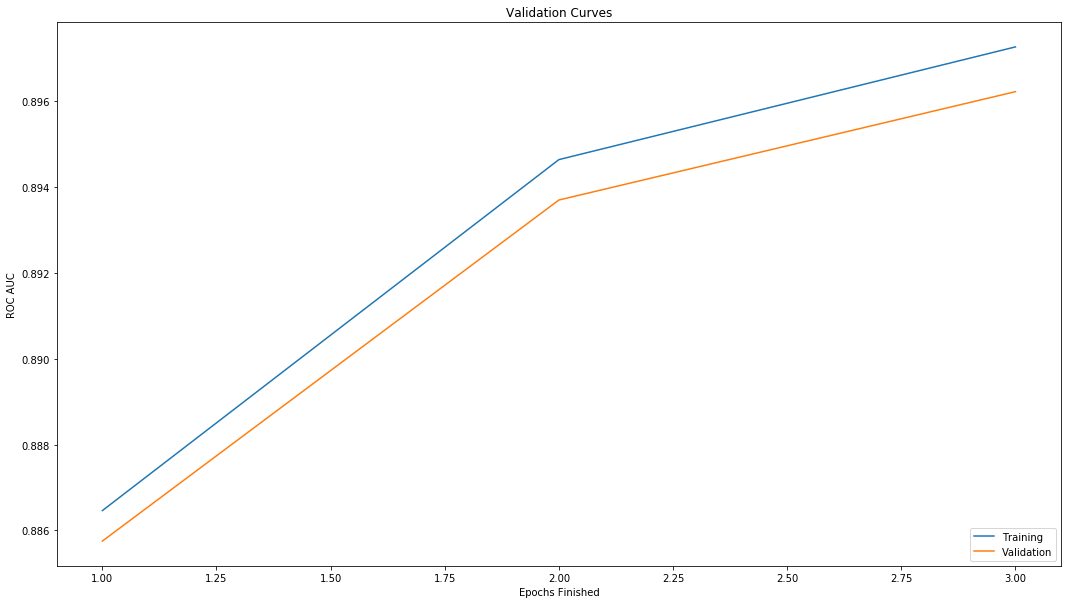

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(range(1, len(val_curve)+1), val_curve)
ax.set_ylabel("ROC AUC")
ax.set_xlabel("Epochs Finished")
ax.set_title("Validation Curves")
handles, _ = ax.get_legend_handles_labels()
labels = ["Training", "Validation"]
plt.legend(handles, labels, loc='lower right')
fig.set_size_inches(18, 10)
fig.savefig("hello.png")

## Evaluate the Model's Accuracy

In [ ]:
correct = 0
total = 0

# For Binary
for data in testloader:
    images, labels = data['input'].float(), data['target'].long()
    outputs = net(Variable(images))
    predicted = th.round(outputs.data).long()
    total += labels.size(0)
    correct += (predicted.view(-1, 1) == labels.view(-1, 1)).sum()
    
print('Accuracy of the network on the {} samples: {:f} %'.format(len(testset), (
    100 * correct / total)))

## Save the Model
Here we only serialize the model parameters, i.e. the weights and such, to be loaded again later as follows:
```python
model = BinaryNet(<input_dim>) # Should be the same input dimensions as before.
model.load_state_dict(th.load(<Path>))
```

In [ ]:
th.save(net.state_dict(), "neural_net.torch")

# Try Another NN Trained on Just the "Raw" Features

In [ ]:
raw_trainset = CollisionDataset("ttH_hadT_cut_raw_train.csv", header=0, target_col=0, index_col=0)
raw_valset = CollisionDataset("ttH_hadT_cut_raw_val.csv", header=0, target_col=0, index_col=0, scaler=raw_trainset.scaler)
raw_testset = CollisionDataset("ttH_hadT_cut_raw_test.csv", header=0, target_col=0, index_col=0, scaler=raw_trainset.scaler)

raw_trainloader = DataLoader(raw_trainset, batch_size=512, shuffle=True, num_workers=5)
raw_testloader = DataLoader(raw_testset, batch_size=512, shuffle=True, num_workers=5)

In [ ]:
raw_input_dim = raw_trainset._X.shape[1]

raw_net = BinaryNet(raw_input_dim)
raw_criterion = nn.BCELoss()
raw_optimizer = optim.Adam(raw_net.parameters())

In [ ]:
for epoch in range(1, 4):
    if epoch%2 == 0: print(epoch)
    for batch in raw_trainloader:
        inputs, targets = Variable(batch['input']).float(), Variable(batch['target']).float().view(-1, 1)
        raw_optimizer.zero_grad()
        
        outputs = raw_net(inputs)
        loss = raw_criterion(outputs, targets)
        loss.backward()
        raw_optimizer.step()
print("Done")

In [ ]:
th.save(raw_net.state_dict(), "raw_neural_net.torch")

# Deep Neural Network on the Basic Features

In [ ]:
dnet = DeepBinaryNet(raw_input_dim)

In [ ]:
for epoch in range(1, 8):
    if epoch%2 == 0: print(epoch)
    for batch in raw_trainloader:
        inputs, targets = Variable(batch['input']).float(), Variable(batch['target']).float().view(-1, 1)
        raw_optimizer.zero_grad()
        
        outputs = dnet(inputs)
        loss = raw_criterion(outputs, targets)
        loss.backward()
        raw_optimizer.step()
print("Done")

In [ ]:
th.save(dnet.state_dict(), "deep_basic_neural_net.torch")

In [ ]:
cut = find_cut(net, trainset, benchmark="acc")
score(net, valset, cut=cut)